In [1]:
import sys
sys.path.append('..')
import config as conf
# import functions.parallelization_functions as parallel_funcs

paths = conf.DataFilePaths()
params = conf.ARIMA_model_parameters()

# import statistics
# import multiprocessing as mp
import numpy as np
import pandas as pd
# import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats
# from statistics import NormalDist

In [2]:
# Load and inspect results - each row is an individual datapoint from one of the conditions/samples
input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}.parquet'
data_df = pd.read_parquet(input_file)
data_df.head()

,sample,model_type,lag_order,difference_degree,moving_average_order,SMAPE_value,MBD_prediction,MBD_inputs,MBD_actual
0,0,control,4,1,4,0.003082,2.643781,"[2.6970115, 2.7251282, 2.6519158, 2.6437809, 2...",2.635646
1,0,ARIMA,4,1,4,0.036665,2.734087,"[2.6970115, 2.7251282, 2.6519158, 2.6437809, 2...",2.635646
2,0,control,4,1,4,0.050420,0.771379,"[0.66885245, 0.70488095, 0.78467882, 0.7713791...",0.811278
3,0,ARIMA,4,1,4,0.168474,0.960530,"[0.66885245, 0.70488095, 0.78467882, 0.7713791...",0.811278
4,0,control,4,1,4,0.018611,2.878416,"[2.7718904, 2.7910652, 2.8576183, 2.8784161, 2...",2.932490


In [3]:
# Calculate the final SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'lag_order', 'difference_degree', 'moving_average_order'])[['SMAPE_value']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'SMAPE_value': 'SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,lag_order,difference_degree,moving_average_order,SMAPE_score
0,0,ARIMA,4,1,4,3.636697
1,0,ARIMA,4,1,6,8.069038
2,0,ARIMA,4,1,8,4.177942
3,0,ARIMA,4,2,4,5.957601
4,0,ARIMA,4,2,6,8.298768


In [10]:
difference_degrees = list(sample_smape_scores_df.difference_degree.unique())
sample_smape_means = sample_smape_scores_df.groupby(['model_type', 'lag_order', 'difference_degree', 'moving_average_order'])[['SMAPE_score']].mean()
sample_smape_means.reset_index(inplace=True, drop=False)
winning_control_smape_means = sample_smape_means[sample_smape_means['model_type'] == 'control'].sort_values(by=['SMAPE_score'])
winning_control_smape_means.reset_index(inplace=True, drop=True)
winning_control_smape = winning_control_smape_means['SMAPE_score'].iloc[0]

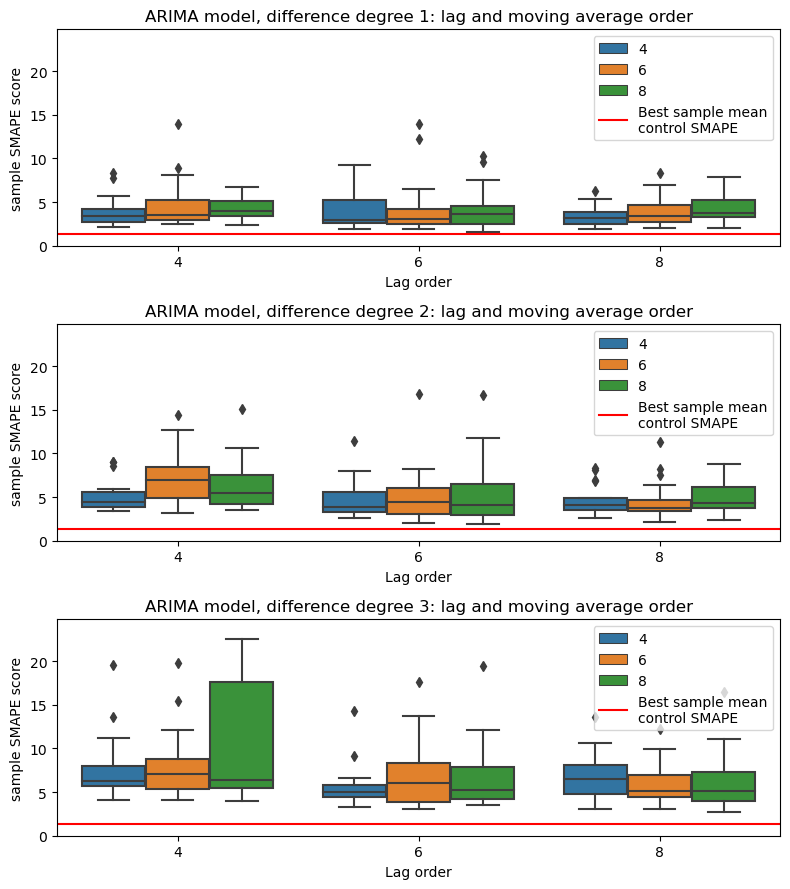

In [11]:
max_smape_score = sample_smape_scores_df[sample_smape_scores_df['model_type'] == 'ARIMA'].sort_values(by=['SMAPE_score'], ascending=False)
max_smape_score.reset_index(inplace=True, drop=True)
max_smape_score = max_smape_score['SMAPE_score'].iloc[0]


fig, ax = plt.subplots(len(difference_degrees), 1, figsize=(8, (3 * len(difference_degrees))))

for degree in difference_degrees:

    sns.boxplot(
        data=sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'ARIMA') & (sample_smape_scores_df['difference_degree'] == degree)], 
        x='lag_order',
        y='SMAPE_score',
        hue='moving_average_order',
        ax=ax[degree - 1]
    )

    ax[degree - 1].set_ylim([0, (max_smape_score + 0.1*max_smape_score)])
    ax[degree - 1].axhline(winning_control_smape, 0, 1, color='red', label=f'Best sample mean\ncontrol SMAPE')

    ax[degree - 1].set(
        xlabel='Lag order', 
        ylabel='sample SMAPE score', 
        title=f'ARIMA model, difference degree {degree}: lag and moving average order'
    )

    ax[degree - 1].legend()

plt.tight_layout()
plt.show()

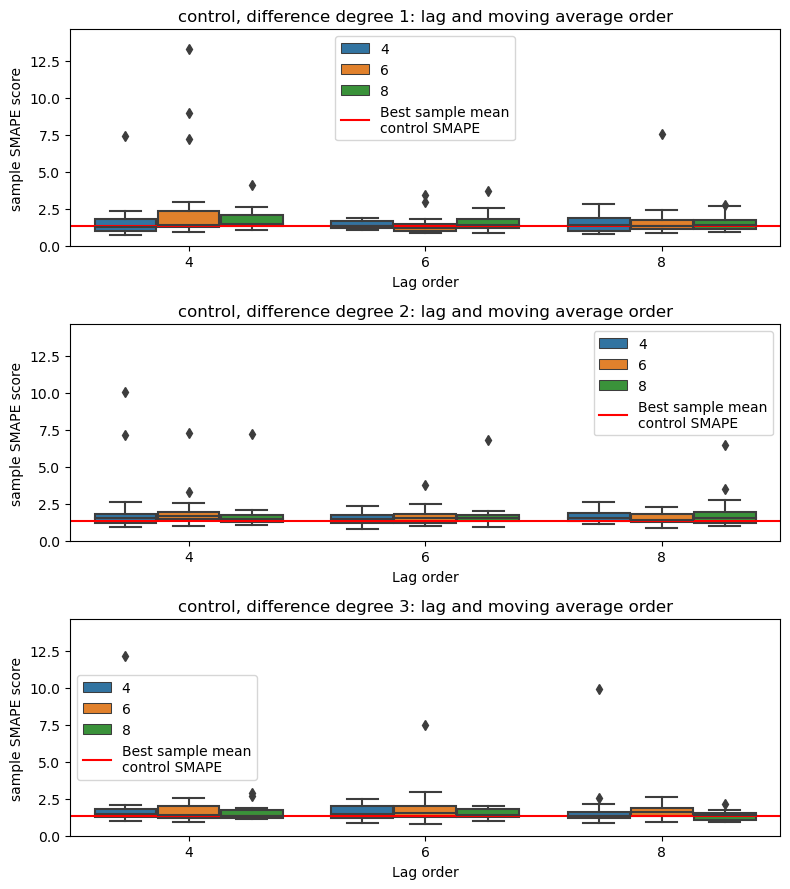

In [12]:
max_smape_score = sample_smape_scores_df[sample_smape_scores_df['model_type'] == 'control'].sort_values(by=['SMAPE_score'], ascending=False)
max_smape_score.reset_index(inplace=True, drop=True)
max_smape_score = max_smape_score['SMAPE_score'].iloc[0]


fig, ax = plt.subplots(len(difference_degrees), 1, figsize=(8, (3 * len(difference_degrees))))

for degree in difference_degrees:

    sns.boxplot(
        data=sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'control') & (sample_smape_scores_df['difference_degree'] == degree)], 
        x='lag_order',
        y='SMAPE_score',
        hue='moving_average_order',
        ax=ax[degree - 1]
    )

    ax[degree - 1].set_ylim([0, (max_smape_score + 0.1*max_smape_score)])
    ax[degree - 1].axhline(winning_control_smape, 0, 1, color='red', label=f'Best sample mean\ncontrol SMAPE')

    ax[degree - 1].set(
        xlabel='Lag order', 
        ylabel='sample SMAPE score', 
        title=f'control, difference degree {degree}: lag and moving average order'
    )

    ax[degree - 1].legend()

plt.tight_layout()
plt.show()